In [1]:
import numpy as np
import pandas as pd
import argparse
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
class ERModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, device, use_hrv,
            dropout_cnn = 0.5, dropout_lstm = 0.8, kernel_size_pool = 5, stride_pool = 4):
        super(ERModel, self).__init__()
        self.device = device
        self.use_hrv = use_hrv
        # CNN stream
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.dropout_cnn = nn.Dropout(p=dropout_cnn)
        self.dropout_lstm = nn.Dropout(p=dropout_lstm)
        self.pool = nn.AvgPool1d(kernel_size=kernel_size_pool, stride=stride_pool)
        # BLSTM stream
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # batch x time_seq x features
        self.blstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size*2 + 64*int((input_size-kernel_size_pool)/4+1), 256)
        self.fc2 = nn.Linear(256, 32)
        if self.use_hrv:
            self.fc3 = nn.Linear(36, num_classes)
        else:
            self.fc3 = nn.Linear(32, num_classes)
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(32)


    def forward(self, x):
        if self.use_hrv:
            x_hrv = x[:,:,-2:]
            x = x[:,:,:-2]
            # print(x_hrv.shape,x.shape)
        # BLSTM stream
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.blstm(x, (h0, c0))
        out = self.dropout_lstm(out[:, -1, :])

        # CNN stream
        x = F.relu(self.conv1(x))
        x = self.dropout_cnn(x)
        x = F.relu(self.conv2(x))
        x = self.dropout_cnn(x)
        x = F.relu(self.conv3(x))
        x = self.dropout_cnn(x)
        x = F.relu(self.conv4(x))
        x = self.dropout_cnn(x)
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        
        # concatenate and fc
        x = torch.cat((x,out),1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # print(x.shape)
        x = torch.cat((x, x_hrv.reshape(x_hrv.shape[0], -1)),1)
        # print(x.shape)
        x = self.fc3(x)

        return x

In [3]:
def load_checkpoint(filename):
    print("=> Loading checkpoint")
    checkpoint = torch.load(filename, map_location="cpu")
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

In [4]:
# model
num_classes = 3
input_size = 60000
hidden_size = 512
num_layers = 2
lr = 0.001
use_hrv = True
device = torch.device("cpu")
model = ERModel(input_size, hidden_size, num_layers, num_classes, device, use_hrv).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [5]:
load_checkpoint('checkpoint/my_checkpoint.pth.tar')

=> Loading checkpoint


In [8]:
ecg = pd.read_csv("user_ecg/2022_5_18_13_49.csv",index_col=False)

In [9]:
ecg

,标志,信号强度,版本号,心率,皮肤电,温度,IBI,x轴加速度,y轴加速度,z轴加速度,步数
0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
181,182,68,143,62,1278,29,848,210,101,75,0
182,183,69,142,57,1282,29,2507,211,101,75,0
183,184,69,141,58,1280,29,843,210,101,75,0
184,185,69,141,58,1279,29,896,210,100,74,0


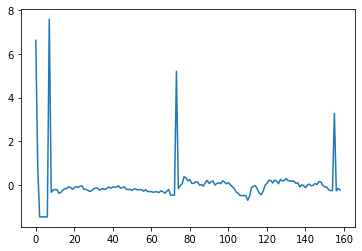

In [18]:
x = np.array([i for i in ecg['IBI'] if i != 0])
x = (x-np.mean(x))/np.std(x)
plt.plot(np.arange(len(x)),x)
x = torch.tensor([x,x])
x = torch.cat((x, torch.zeros(2,input_size - x.shape[1])),1)
ibi = np.array([i/256 for i in ecg['IBI'] if i != 0])
mean = np.mean(ibi)
std = np.std(ibi)
x = torch.cat((x, torch.tensor([[mean,std], [mean,std]])),1).unsqueeze(0).float()

In [19]:
std

1.8290698435192396

In [20]:
res = model(x)
res = res[0].detach().numpy()
res

array([ 8.382352,  8.439748, 13.261678], dtype=float32)

In [21]:
def map_score_emo(score):
    # map 3 scores to specific emotion: 
    # calmness 322, happiness 433, fear 244, sadness 133, anger 144, excitement 333
    
    # val positive or negative
    # aro bored or excited
    # dom without control or empowered
    
    emotion = np.array([[3.17, 2.26, 2.09], [4.39, 3.44, 3.65], [2.26, 3.67, 3.67], 
                    [1.52, 3.00, 3.96], [1.85, 3.09, 3.37], [3.44, 3.53, 3.39]])
    out = np.zeros(6)
    for i in range(len(emotion)):
        temp = (score - emotion[i])**2
        out[i] = 100*(2*temp[0] + temp[1] + temp[2])
    out = max(out)-out+1
    out /= sum(out)
    
    return out

In [22]:
map_score_emo(res)

array([6.44187755e-05, 4.38584388e-01, 1.77961568e-01, 4.53964209e-02,
       3.56529480e-02, 3.02340257e-01])